# Gradient Boosting Challenge
Unit 3 / Lesson 5 / Project 3

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.
Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.

Strategies you might use include:
* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [2]:
# import data
PATH = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv"
)
df = pd.read_csv(PATH).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
data = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
target = df['partner'] - 1

# Make the categorical variable 'country' into dummies.
data = pd.concat([data, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
# Put 80% of the data in the training set.
# And put 20% in the test set.
from sklearn.model_selection import train_test_split
# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42, stratify=None)

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators':500,
          'max_depth':2,
          'loss':'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04557311646463096
Percent Type II errors: 0.17999079330980514

Test set accuracy:
Percent Type I errors: 0.05705521472392638
Percent Type II errors: 0.17975460122699385


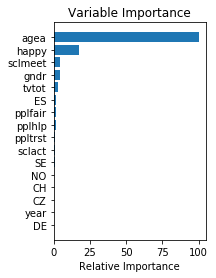

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sorted_idx], align='center')

plt.yticks(pos, data.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Parameter EDA

Fit a gradient boosting classifier with default parameters to get a baseline for performance.

In [5]:
# set default parameters
params = {'n_estimators':500,
          'max_depth':2,
          'loss':'deviance'}

model = ensemble.GradientBoostingClassifier(**params)

model.fit(X_train, y_train)

y_pred = y_pred = model.predict(X_test)

We will use AUC (Area Under Curve) as the evaluation metric.

In [6]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7212822965596342

Learning rate shrinks the contribution of each tree by learning_rate.

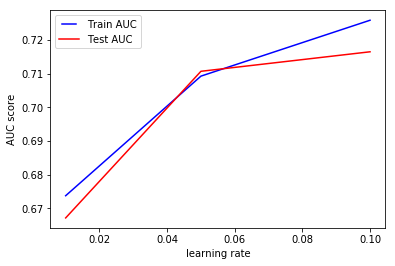

In [7]:
learning_rates = [0.1, 0.05, 0.01]
train_results = []
test_results = []

for eta in learning_rates:
   model = ensemble.GradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

Using a high learning rate results in overfitting.
For this data, a learning rate of 0.1 is optimal.

`n_estimators` represents the number of trees in the forest.
Usually the more trees there are, the better the model fits the data.
However adding a lot of trees can slow down the training process considerably.
let's do a parameter search to find the sweet spot.

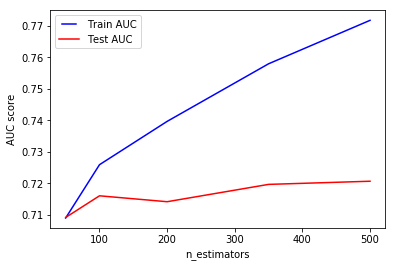

In [8]:
n_estimators = [50, 100, 200, 350, 500]
train_results = []
test_results = []

for estimator in n_estimators:
   model = ensemble.GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

Increasing the number of estimators may result in overfitting.
In our case, we can use a higher number of estimators (>75) without risk of overfitting.

`max_depth` indicates how deep the built tree can be.
The deeper the tree, the more splits it has and the more it captures the data.
We fit a decision tree with depths ranging from 1 to 32 and plot the training and test errors.

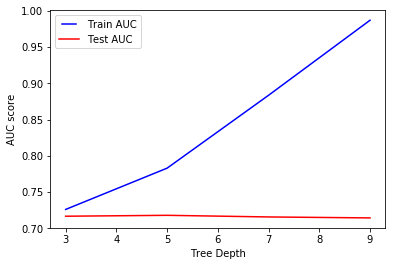

In [9]:
max_depths = list(range(3, 11, 2))
train_results = []
test_results = []

for max_depth in max_depths:
   model = ensemble.GradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

`min_samples_split` represents the minimum number of samples required to split an internal node.
This can vary between considering at least one sample at each node to considering all of the samples at each node.
When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node.
Here we will vary the parameter from 10% to 100% of the samples.

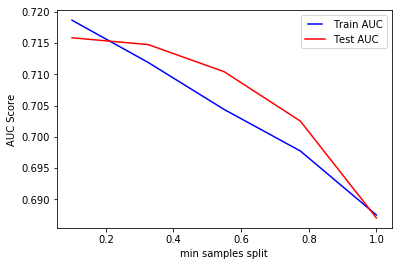

In [10]:
min_samples_splits = np.linspace(0.1, 1.0, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
   model = ensemble.GradientBoostingClassifier(min_samples_split=min_samples_split)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('min samples split')
plt.show()

It looks like the model performs best when `min_samples_split` utilizes 50%-90% of the samples at each node.
Outside of that range, it risks underfitting the data.

`min_samples_leaf` is The minimum number of samples required at a leaf node.
This similar to `min_samples_splits`, however, this describes the minimum number of samples at each leaf.

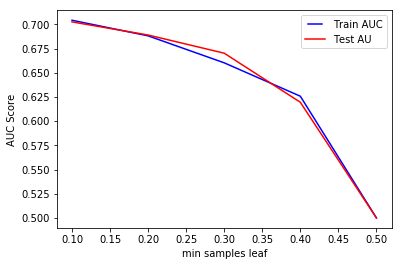

In [11]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
   model = ensemble.GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AU")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('min samples leaf')
plt.show()

Looks like increasing our `min_samples_leaf` doesn't cause our model to overfit.

`max_features` represents the number of features to consider when looking for the best split.

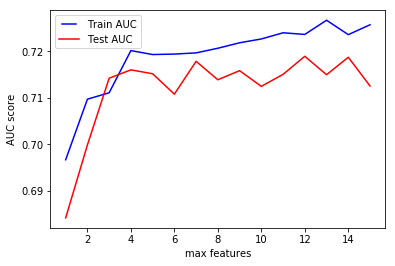

In [12]:
max_features = list(range(1,data.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
   model = ensemble.GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

It looks like increasing `max_features` will improve our model and potentially decrease the likelihood of overfitting.

### Parameter Optimization

In [13]:
# import GridSearch
from sklearn.model_selection import GridSearchCV
# import random search
from sklearn.model_selection import RandomizedSearchCV

# define our parameter ranges
param_grid = {
    'learning_rate':[0.1, 0.05, 0.01],
    'n_estimators':[50, 100, 200, 350, 500],
    'subsample':np.linspace(0.5, 1.0, num=5, endpoint=True),
#    'min_samples_split':list(range()),
#    'min_samples_leaf':list(range()),
    'max_depth':list(range(3, 11, 2)),
#    'max_features':list(range(1,data.shape[1])),
#    'warm_start':[False, True],
    'loss':['deviance', 'exponential'],
}

# sample 30% of training data
# stratified split
# import random  
#from random import sample


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier()
#clf = GridSearchCV(clf, param_grid, cv=3)
clf = RandomizedSearchCV(clf, param_grid, cv=3)
# pass subset of data
clf.fit(X_train, y_train)

# get the best parameters
clf.best_params_

{'subsample': 0.75,
 'n_estimators': 100,
 'max_depth': 3,
 'loss': 'deviance',
 'learning_rate': 0.05}

In [14]:
# refit model with best parameters
best_params = clf.best_params_
clf_best = ensemble.GradientBoostingClassifier(**best_params)
clf_best.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.75, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [15]:
#
predict_train_best = clf_best.predict(X_train)
predict_test_best = clf_best.predict(X_test)

# Accuracy tables.
table_train_best = pd.crosstab(y_train, predict_train_best, margins=True)
table_test_best = pd.crosstab(y_test, predict_test_best, margins=True)

train_tI_errors_best = table_train_best.loc[0.0,1.0] / table_train_best.loc['All','All']
train_tII_errors_best = table_train_best.loc[1.0,0.0] / table_train_best.loc['All','All']

test_tI_errors_best = table_test_best.loc[0.0,1.0]/table_test_best.loc['All','All']
test_tII_errors_best = table_test_best.loc[1.0,0.0]/table_test_best.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors_best, train_tII_errors_best,
         test_tI_errors_best, test_tII_errors_best))

Training set accuracy:
Percent Type I errors: 0.04020254718428725
Percent Type II errors: 0.19671628049716128

Test set accuracy:
Percent Type I errors: 0.041104294478527606
Percent Type II errors: 0.1950920245398773


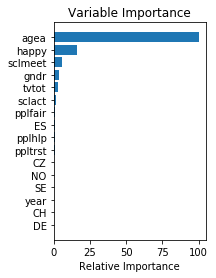

In [16]:
feature_importance_best = clf_best.feature_importances_

# Make importances relative to max importance.
feature_importance_best = 100.0 * (feature_importance_best / feature_importance_best.max())
sorted_idx = np.argsort(feature_importance_best)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance_best[sorted_idx], align='center')
plt.yticks(pos, data.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It looks like boosting our model with randomized parameter optimization, subsampling, and chaning our loss function didn't produce exactly the results we had hoped for.

Our optimized model actually resulted in increasing the Type II errors in our test set from 18% to 19%.

If we wanted to take this further, we could reapproach the feature selection and engineering process.